In [213]:
# import Libraries

import tweepy
import pandas as pd
import numpy as np
import string
import re

import preprocessor as p
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from textblob import TextBlob

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\waleed
[nltk_data]     traders\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# twitter App access keys for @user
 
# Consumer
CONSUMER_KEY    = 'xxxxxxxxxxxxxxxxxxxx'
CONSUMER_SECRET = 'xxxxxxxxxxxxxxxxxxxx'
 
# Access:
ACCESS_TOKEN  = 'xxxxxxxxxxxxxxxxxxxx'
ACCESS_SECRET = 'xxxxxxxxxxxxxxxxxxxx'

In [215]:
def app_auth():
    
    """
    Authenticate our program using the credentials,
    then create a Twitter API object with the credentials
    """
    
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    
    api = tweepy.API(auth)
    return api

In [216]:
tweet_extract = app_auth()

# input for term to be searched and how many tweets to search

search_term = input("Enter keyword or tag to search: ")
no_of_terms = int(input("Enter no: of tweets to search: "))

tweets = tweet_extract.user_timeline(screen_name = search_term, count = no_of_terms)
print("number of tweets extracted: {}.\n".format(len(tweets)))
 
print("10 latest tweets are :\n")
for tweet in tweets[:10]:
    print(tweet.text)
    print('\n')

Enter keyword or tag to search: Who
Enter no: of tweets to search: 200
number of tweets extracted: 200.

10 latest tweets are :

Between January &amp; April, WHO provided #COVID19 testing laboratory supplies to all 22 countries of @WHOEMRO.
In… https://t.co/qxgu6IDLCm


To stay #HealthyAtHome during the #COVID19 outbreak:

Stay hydrated. Drink plenty of water. https://t.co/2MNeSayccH


To stay #HealthyAtHome during the #COVID19 outbreak:

Eat moderate amounts of fats and oils. Avoid trans fats. https://t.co/IpWzNgnbbG


To stay #HealthyAtHome during the #COVID19 outbreak:

Avoid drinking alcohol or keep it to the minimum if you drink… https://t.co/yQ7TWHGwM5


To stay #HealthyAtHome during the #COVID19 outbreak:

Reduce sugar consumption. 
Limit intake of sweets and sugary… https://t.co/delO4ZAfxg


To stay #HealthyAtHome during the #COVID19 outbreak:

Cut back on 🧂. Limit salt intake to less than 5 grams (a teas… https://t.co/O16QDfjlQy


To stay #HealthyAtHome during the #COVID19 out

In [217]:
# Creating a DataFrame of fetch tweets

df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
df['ID'] = np.array([tweet.id for tweet in tweets])
df['Date'] = np.array([tweet.created_at for tweet in tweets])
df['Source'] = np.array([tweet.source for tweet in tweets])
df['Likes'] = np.array([tweet.favorite_count for tweet in tweets])
df['Retweets'] = np.array([tweet.retweet_count for tweet in tweets])
display(df.head(10))

,Tweets,ID,Date,Source,Likes,Retweets
0,"Between January &amp; April, WHO provided #COV...",1262079141433745408,2020-05-17 17:54:50,Twitter Web App,120,38
1,To stay #HealthyAtHome during the #COVID19 out...,1262076402792378368,2020-05-17 17:43:57,Twitter for iPhone,160,71
2,To stay #HealthyAtHome during the #COVID19 out...,1262068935224168449,2020-05-17 17:14:16,Twitter for iPhone,282,97
3,To stay #HealthyAtHome during the #COVID19 out...,1262062634976915457,2020-05-17 16:49:14,Twitter Web App,295,105
4,To stay #HealthyAtHome during the #COVID19 out...,1262056151769919488,2020-05-17 16:23:29,Twitter Web App,358,160
5,To stay #HealthyAtHome during the #COVID19 out...,1262036176040591363,2020-05-17 15:04:06,Twitter Web App,371,154
6,To stay #HealthyAtHome during the #COVID19 out...,1262030559196459009,2020-05-17 14:41:47,Twitter Web App,317,109
7,⛹️‍♂️ #BeActive &amp; stay healthy during #COV...,1262009098809344000,2020-05-17 13:16:30,Twitter Web App,188,50
8,Here are some ideas from \n@FIFAcom\n for you ...,1262005691293802496,2020-05-17 13:02:58,Twitter Web App,146,43
9,Here are some #HealthyAtHome ideas for older a...,1261999122602774529,2020-05-17 12:36:52,Twitter Web App,218,99


Creation of content sources:
* Twitter Web App
* Twitter for iPhone
* Periscope
* Socialbakers


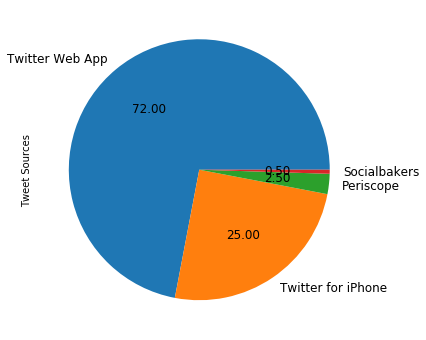

In [218]:
sources = []
for source in df['Source']:
    if source not in sources:
        sources.append(source)
        
        
# We print sources list:

print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

# We create a numpy vector mapped to labels:

percent = np.zeros(len(sources))
 
for source in df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100
    
# Pie chart:

pie_chart = pd.Series(percent, index=sources, name='Tweet Sources')
pie_chart.plot.pie(fontsize=12, autopct='%.2f', figsize=(6, 6));

In [220]:
# Create a series from array
tweets_liked = pd.Series(data = df['Likes'].values)   
tweets_retweeted = pd.Series(data = df['Retweets'].values) 

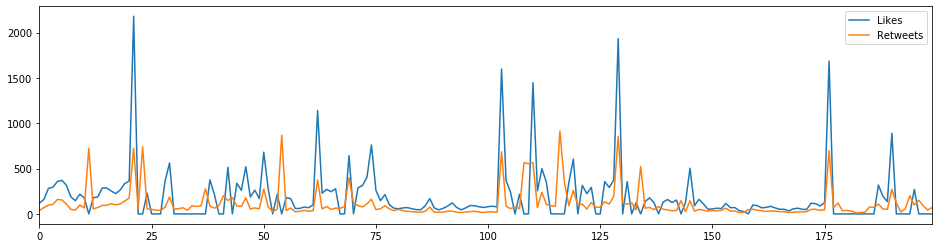

In [221]:
# Likes vs retweets visualization:

tweets_liked.plot(figsize=(16,4), label="Likes", legend=True)
tweets_retweeted.plot(figsize=(16,4), label="Retweets", legend=True)

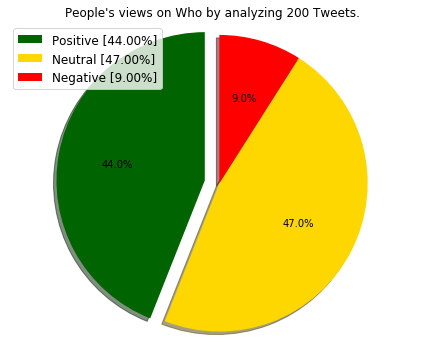

In [222]:

# creating some variables to store info

polarity = 0
positive = 0
negative = 0
neutral = 0
        
positive_word = []
negtive_word = []

#tweets = []
tweet_text = []


def clean_tweet(tweet):
    
    """
     Clean data by remove Links, Special Characters etc from tweet
    """
 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w +:\ / \ / \S +)", " ", tweet).split())


def calculate_percentage(part, whole):
    
    """
    Calculate percentage of tweets polarity
    
    """
    temp = 100 * float(part) / float(whole)
    return format(temp, '.2f')


def plot_chart(positive, neutral, negative, search_term, no_of_terms):
    
    """
    Draw pie chart showing classification of sentimets 
    """
     
    labels = ['Positive [' + str(positive) + '%]', 'Neutral [' + str(neutral) + '%]','Negative [' + str(negative) + '%]']
    sizes = [positive, neutral, negative]
    colors = ['darkgreen', 'gold', 'red']
    explode = (0.1, 0, 0)
    fig1, ax1 = plt.subplots(figsize=(6, 5))
    ax1.pie(sizes,colors= colors, explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
    plt.legend(labels, loc="upper left" , prop={'size': 12})
    plt.title('People\'s views on ' + search_term + ' by analyzing ' + str(no_of_terms) + ' Tweets.')
    ax1.axis('equal')
    plt.tight_layout()
    plt.show()
    
    

# iterating through tweets fetched
for tweet in tweets:
    
    #Append to temp so that we can store in csv later. I use encode UTF-8
    tweet_text.append(clean_tweet(tweet.text).encode('utf-8'))
    
    # print (tweet.text.translate(non_bmp_map))    #print tweet's text
    analysis = TextBlob(tweet.text)
    
    # print(analysis.sentiment)  # print tweet's polarity
    polarity += analysis.sentiment.polarity
    
    # adding reaction of how people are reacting to find average later
    
    if (analysis.sentiment.polarity == 0): 
        neutral += 1
    elif (analysis.sentiment.polarity > 0 ):
        positive_word.append(tweet.text)
        positive += 1
    elif (analysis.sentiment.polarity < 0):
        negtive_word.append(tweet.text)
        negative += 1
              

            
# finding average of people's sentiments
positive = calculate_percentage(positive, no_of_terms)
negative = calculate_percentage(negative, no_of_terms)
neutral = calculate_percentage(neutral, no_of_terms)

plot_chart(positive, neutral, negative, search_term, no_of_terms)

In [225]:
def extract_hashtags(tweets):
    
    """
    Collect hashtags from tweets list by find tweets 
    that start with #
    """
    
    hashtags = []
    # Loop over the words in the tweet
    for tweet in tweets:
        hashtag = re.findall(r"#(\w+)", tweet.text)
        hashtags.append(hashtag)

    return hashtags

# extracting hashtags from tweets
hashtag = extract_hashtags(tweets)
# unnesting list
hashtag = sum(hashtag,[])

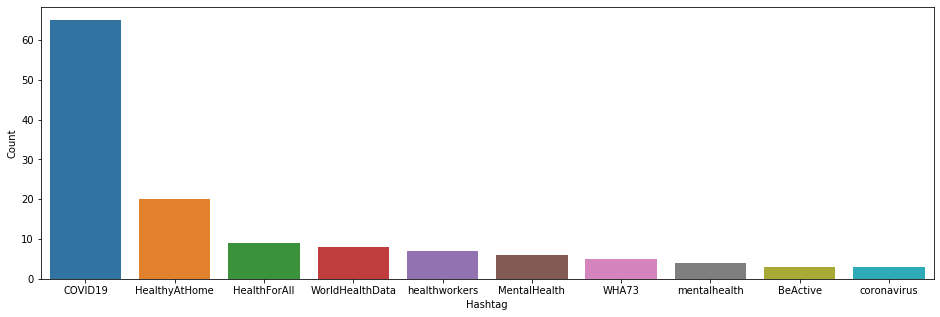

In [226]:
a = nltk.FreqDist(hashtag)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [228]:
def draw_wordcloud(tweets, color = 'black'):
    
    
    words = ' '.join(tweets)
    cleaned_word = " ".join([word for word in words.split() 
                             if 'http' not in word
                                    and not word.startswith('@')
                                    and not word.startswith('#')
                                    and word != 'RT'
                            ])
    
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color=color,
                          max_words=100,
                          width=3000,
                          height=1000
                         ).generate(cleaned_word)
    plt.figure(figsize=(13, 13))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

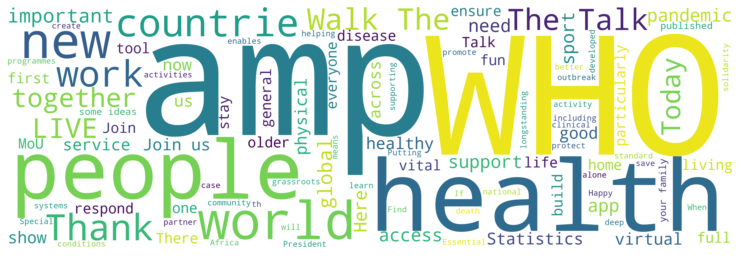

In [229]:
draw_wordcloud(positive_word, 'white')

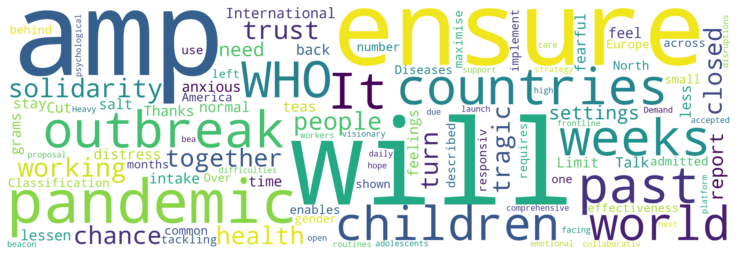

In [230]:
draw_wordcloud(negtive_word,'white')